In [1]:
import dlc_practical_prologue as prologue

In [2]:
import torch
import time
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
# sometimes download directly will have the http403 error. If that happen, then use this code.
from six.moves import urllib
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#*********************** 

In [4]:
# load data
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

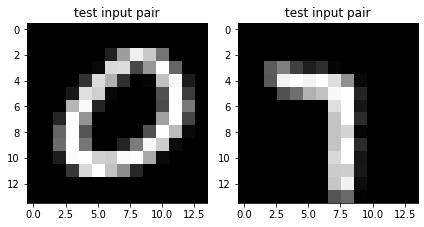

The test classes are: 0 and 7.
The test target is: 0


In [5]:
# discribe the data
fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(test_input[0][i], cmap='gray')
  plt.title("test input pair")  
  plt.tight_layout()
plt.show()
print("The test classes are: %d and %d."%(test_classes[0][0].item(),test_classes[0][1].item()))
print("The test target is: %d"%(train_target[0]))

In [6]:
# understand the data of the training and testing data
print(train_input.shape)
print(train_input.dtype)
print(train_target.shape)
print(train_target.dtype)
print(train_classes.shape)
print(test_classes.shape)
print(train_classes[0])

torch.Size([1000, 2, 14, 14])
torch.float32
torch.Size([1000])
torch.int64
torch.Size([1000, 2])
torch.Size([1000, 2])
tensor([9, 3])


In [7]:
#weights_sharing_CNN
# What the weight sharing does is using both the 2000 images together to train the same layer, 
# which will be better than purely using 1000 images
class CNN_Net_weight_sharing_auxiliary_loss(nn.Module):
    def __init__(self):
        super(CNN_Net_weight_sharing_auxiliary_loss, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32,64,kernel_size=2)
        self.conv2_drop=nn.Dropout2d()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(20,200)
        self.fc4 = nn.Linear(200,200)
        self.fc5 = nn.Linear(200,2)
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x):
#         print(x.shape)
        img1 = x[:,0,:,:].view(-1,1,14,14)
        img2 = x[:,1,:,:].view(-1,1,14,14)
        
        
        # weight sharing
        img1 = F.relu(F.max_pool2d(self.conv1(img1), kernel_size=2, stride=2))
        img1 = F.relu(F.max_pool2d(self.conv2(img1), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.conv1(img2), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.conv2(img2), kernel_size=2, stride=2))

#       detect the img1 figure 
        
        output1 = img1.view(-1,256)
        output1 = F.relu(self.fc1(output1))
        output1 = self.fc2(output1)
#       detect the img2 figure
        output2 = img2.view(-1,256)
        output2 = F.relu(self.fc1(output2))
        output2 = self.fc2(output2)

        output = torch.cat((output1,output2),1)      
        output = F.relu(self.fc3(output))
        output = F.relu(self.fc4(output))
        output = self.fc5(output)
        
        return output, output1, output2

        # Training Function with auxiliary_loss

    def trainer(self, train_input, train_target, train_classes, test_input, test_target, test_classes):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        :param train_classes: Training classes
        :param test_input: Testing features
        :param test_target: Training labels
        :output the loss plot
        """
        start_time = time.time()
#         self.train()
        train_loss_history=[]
        test_loss_history=[]
        train_accuracy=[]
        test_accuracy=[]
        for epoch in range(self.num_epochs):
            # train mode
            self.train()
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output, output1, output2 = self(train_input[batch_idx:batch_idx+self.batch_size])
#                 output = self(train_input[batch_idx:batch_idx+self.batch_size])
                target = train_target[batch_idx:batch_idx+self.batch_size]
#                 print(output.shape)
#                 print(target.shape)
                class1 = train_classes[batch_idx:batch_idx+self.batch_size,0]
                class2 = train_classes[batch_idx:batch_idx+self.batch_size,1]
                loss = self.criterion(output, target)+0.5*self.criterion(output1, class1)+0.5*self.criterion(output2, class2)
                #gradients to zero
                self.optimizer.zero_grad()                          
                #backpropagation
                loss.backward() 
                self.optimizer.step()         
#                 every 50 batch_idx, output the loss
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            # test mode
            self.eval()
            # get the training loss and accuracy
            train_predicted, train_output1, train_output2 = self(train_input)
            train_loss = self.criterion(train_predicted, train_target)+0.5*self.criterion(train_output1, train_classes[:,0])+0.5*self.criterion(train_output2, train_classes[:,1])
            train_loss_history.append(train_loss)
            _, train_pred = torch.max(train_predicted, 1)   #return the index of the bigger result
            train_accuracy_result=self.compute_accuracy(train_target,train_pred)
            train_accuracy.append(train_accuracy_result)

            # get the testing loss and accuracy
            test_predicted, test_output1, test_output2 = self(test_input)
            test_loss = self.criterion(test_predicted, test_target)+0.5*self.criterion(test_output1, test_classes[:,0])+0.5*self.criterion(test_output2, test_classes[:,1])
            test_loss_history.append(test_loss)
            _, test_pred = torch.max(test_predicted, 1)   #return the index of the bigger result
            test_accuracy_result=self.compute_accuracy(test_target,test_pred)
            test_accuracy.append(test_accuracy_result)
            
            
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
        # plot the accuracy and loss figure
            #Plotting the train and test loss and accuracy figure

        #Setting-up the plot
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(1,2,1)

        ax2 = plt.subplot(1,2,2)

        #Drawing and labeling the curves
        ax1.plot(train_loss_history, label="Training Loss")
        ax1.plot(test_loss_history, label="Test Loss")

        #Adding the title and axis labels
        ax1.set_title('Train VS Test Loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()

    #     #Saving the plot
    #     ax1.figure.savefig(model.model_name+'loss.png')


        #Drawing and labeling the curves
        ax2.plot(train_accuracy, label="Train Accuracy")
        ax2.plot(test_accuracy, label="Test Accuracy")

        #Adding the title and axis labels
        ax2.set_title('Train VS Test Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()

        #Saving the plot
    #     ax2.figure.savefig(model.model_name+'accuracy.png')
        plt.savefig('accuracy_loss.png')

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set with batch_size
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
    
        #test mode
        self.eval()
        outputs,_,_ = self(input_data)
        _, predicted = torch.max(outputs, 1)
        return 1-self.compute_accuracy(target,predicted)

    def compute_accuracy(self, target, pred):
        """
        Compute the training and testing error
        :param target: target data (whether 1 or 0)
        :param pred: predicted data
        :return 
        """
        return (target-pred).eq(0).float().mean().item()
    
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        :output the model pth.
        """         
        torch.save(self, './model/'+ model_name)

In [8]:
# build an net instance
my_model=CNN_Net_weight_sharing_auxiliary_loss()
# save the model
my_model.save_model('CNN_Net_weight_sharing_auxiliary_loss.pth')

Epoch: 001/025 | Batch 000/1000 | Loss: 13.507441
Epoch: 001/025 | Batch 050/1000 | Loss: 10.722267
Epoch: 001/025 | Batch 100/1000 | Loss: 11.588915
Epoch: 001/025 | Batch 150/1000 | Loss: 9.104790
Epoch: 001/025 | Batch 200/1000 | Loss: 9.151075
Epoch: 001/025 | Batch 250/1000 | Loss: 7.493074
Epoch: 001/025 | Batch 300/1000 | Loss: 7.671544
Epoch: 001/025 | Batch 350/1000 | Loss: 7.947404
Epoch: 001/025 | Batch 400/1000 | Loss: 7.567657
Epoch: 001/025 | Batch 450/1000 | Loss: 6.748446
Epoch: 001/025 | Batch 500/1000 | Loss: 6.443242
Epoch: 001/025 | Batch 550/1000 | Loss: 6.416077
Epoch: 001/025 | Batch 600/1000 | Loss: 5.802615
Epoch: 001/025 | Batch 650/1000 | Loss: 5.738723
Epoch: 001/025 | Batch 700/1000 | Loss: 4.646677
Epoch: 001/025 | Batch 750/1000 | Loss: 5.150214
Epoch: 001/025 | Batch 800/1000 | Loss: 4.575981
Epoch: 001/025 | Batch 850/1000 | Loss: 4.872907
Epoch: 001/025 | Batch 900/1000 | Loss: 4.418187
Epoch: 001/025 | Batch 950/1000 | Loss: 3.551989
Time elapsed: 0.0

Epoch: 009/025 | Batch 800/1000 | Loss: 0.794855
Epoch: 009/025 | Batch 850/1000 | Loss: 1.101865
Epoch: 009/025 | Batch 900/1000 | Loss: 0.823153
Epoch: 009/025 | Batch 950/1000 | Loss: 0.752250
Time elapsed: 0.07 min
Epoch: 010/025 | Batch 000/1000 | Loss: 1.126290
Epoch: 010/025 | Batch 050/1000 | Loss: 0.932604
Epoch: 010/025 | Batch 100/1000 | Loss: 0.908965
Epoch: 010/025 | Batch 150/1000 | Loss: 0.911708
Epoch: 010/025 | Batch 200/1000 | Loss: 0.784774
Epoch: 010/025 | Batch 250/1000 | Loss: 0.825746
Epoch: 010/025 | Batch 300/1000 | Loss: 0.982004
Epoch: 010/025 | Batch 350/1000 | Loss: 0.804311
Epoch: 010/025 | Batch 400/1000 | Loss: 1.094745
Epoch: 010/025 | Batch 450/1000 | Loss: 0.931192
Epoch: 010/025 | Batch 500/1000 | Loss: 1.150496
Epoch: 010/025 | Batch 550/1000 | Loss: 1.013368
Epoch: 010/025 | Batch 600/1000 | Loss: 0.861202
Epoch: 010/025 | Batch 650/1000 | Loss: 0.871150
Epoch: 010/025 | Batch 700/1000 | Loss: 0.770832
Epoch: 010/025 | Batch 750/1000 | Loss: 0.8849

Time elapsed: 0.13 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.591598
Epoch: 018/025 | Batch 050/1000 | Loss: 0.487913
Epoch: 018/025 | Batch 100/1000 | Loss: 0.430188
Epoch: 018/025 | Batch 150/1000 | Loss: 0.451803
Epoch: 018/025 | Batch 200/1000 | Loss: 0.401316
Epoch: 018/025 | Batch 250/1000 | Loss: 0.505961
Epoch: 018/025 | Batch 300/1000 | Loss: 0.581316
Epoch: 018/025 | Batch 350/1000 | Loss: 0.386679
Epoch: 018/025 | Batch 400/1000 | Loss: 0.636661
Epoch: 018/025 | Batch 450/1000 | Loss: 0.502294
Epoch: 018/025 | Batch 500/1000 | Loss: 0.701335
Epoch: 018/025 | Batch 550/1000 | Loss: 0.530125
Epoch: 018/025 | Batch 600/1000 | Loss: 0.430194
Epoch: 018/025 | Batch 650/1000 | Loss: 0.399070
Epoch: 018/025 | Batch 700/1000 | Loss: 0.479454
Epoch: 018/025 | Batch 750/1000 | Loss: 0.526241
Epoch: 018/025 | Batch 800/1000 | Loss: 0.349680
Epoch: 018/025 | Batch 850/1000 | Loss: 0.557885
Epoch: 018/025 | Batch 900/1000 | Loss: 0.409678
Epoch: 018/025 | Batch 950/1000 | Loss: 0.3430

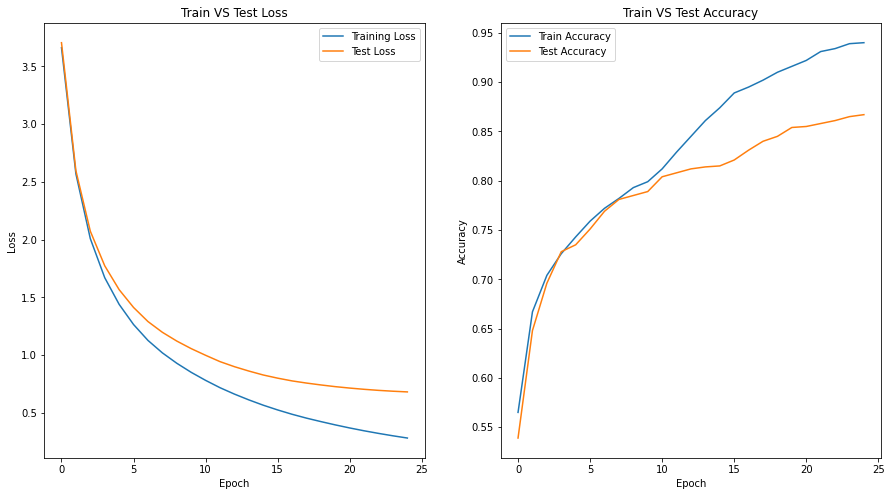

In [9]:
# train the model
my_model.trainer(train_input, train_target,train_classes, test_input, test_target,test_classes)

In [10]:
# output the total number of parameters
print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

The total number of the parameters is: 88076


Epoch: 001/025 | Batch 000/1000 | Loss: 9.851889
Epoch: 001/025 | Batch 050/1000 | Loss: 8.566359
Epoch: 001/025 | Batch 100/1000 | Loss: 7.276674
Epoch: 001/025 | Batch 150/1000 | Loss: 6.729246
Epoch: 001/025 | Batch 200/1000 | Loss: 6.195128
Epoch: 001/025 | Batch 250/1000 | Loss: 6.061328
Epoch: 001/025 | Batch 300/1000 | Loss: 5.541153
Epoch: 001/025 | Batch 350/1000 | Loss: 5.623264
Epoch: 001/025 | Batch 400/1000 | Loss: 6.052249
Epoch: 001/025 | Batch 450/1000 | Loss: 5.275116
Epoch: 001/025 | Batch 500/1000 | Loss: 5.459220
Epoch: 001/025 | Batch 550/1000 | Loss: 5.552031
Epoch: 001/025 | Batch 600/1000 | Loss: 5.183830
Epoch: 001/025 | Batch 650/1000 | Loss: 5.033340
Epoch: 001/025 | Batch 700/1000 | Loss: 4.676234
Epoch: 001/025 | Batch 750/1000 | Loss: 4.247711
Epoch: 001/025 | Batch 800/1000 | Loss: 4.307469
Epoch: 001/025 | Batch 850/1000 | Loss: 4.381940
Epoch: 001/025 | Batch 900/1000 | Loss: 3.745157
Epoch: 001/025 | Batch 950/1000 | Loss: 3.831565
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 750/1000 | Loss: 0.872349
Epoch: 009/025 | Batch 800/1000 | Loss: 0.952192
Epoch: 009/025 | Batch 850/1000 | Loss: 1.064873
Epoch: 009/025 | Batch 900/1000 | Loss: 0.849418
Epoch: 009/025 | Batch 950/1000 | Loss: 0.852442
Time elapsed: 0.07 min
Epoch: 010/025 | Batch 000/1000 | Loss: 1.010800
Epoch: 010/025 | Batch 050/1000 | Loss: 0.748899
Epoch: 010/025 | Batch 100/1000 | Loss: 0.902990
Epoch: 010/025 | Batch 150/1000 | Loss: 0.953175
Epoch: 010/025 | Batch 200/1000 | Loss: 0.841799
Epoch: 010/025 | Batch 250/1000 | Loss: 0.967080
Epoch: 010/025 | Batch 300/1000 | Loss: 1.067516
Epoch: 010/025 | Batch 350/1000 | Loss: 0.709119
Epoch: 010/025 | Batch 400/1000 | Loss: 0.887618
Epoch: 010/025 | Batch 450/1000 | Loss: 0.889722
Epoch: 010/025 | Batch 500/1000 | Loss: 0.727499
Epoch: 010/025 | Batch 550/1000 | Loss: 0.923666
Epoch: 010/025 | Batch 600/1000 | Loss: 0.889081
Epoch: 010/025 | Batch 650/1000 | Loss: 0.868204
Epoch: 010/025 | Batch 700/1000 | Loss: 0.7970

Time elapsed: 0.14 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.627179
Epoch: 018/025 | Batch 050/1000 | Loss: 0.467502
Epoch: 018/025 | Batch 100/1000 | Loss: 0.435525
Epoch: 018/025 | Batch 150/1000 | Loss: 0.478761
Epoch: 018/025 | Batch 200/1000 | Loss: 0.470956
Epoch: 018/025 | Batch 250/1000 | Loss: 0.572633
Epoch: 018/025 | Batch 300/1000 | Loss: 0.656432
Epoch: 018/025 | Batch 350/1000 | Loss: 0.427585
Epoch: 018/025 | Batch 400/1000 | Loss: 0.529410
Epoch: 018/025 | Batch 450/1000 | Loss: 0.560763
Epoch: 018/025 | Batch 500/1000 | Loss: 0.378625
Epoch: 018/025 | Batch 550/1000 | Loss: 0.538885
Epoch: 018/025 | Batch 600/1000 | Loss: 0.493457
Epoch: 018/025 | Batch 650/1000 | Loss: 0.443234
Epoch: 018/025 | Batch 700/1000 | Loss: 0.396508
Epoch: 018/025 | Batch 750/1000 | Loss: 0.426609
Epoch: 018/025 | Batch 800/1000 | Loss: 0.465856
Epoch: 018/025 | Batch 850/1000 | Loss: 0.560865
Epoch: 018/025 | Batch 900/1000 | Loss: 0.508039
Epoch: 018/025 | Batch 950/1000 | Loss: 0.3855

Epoch: 001/025 | Batch 800/1000 | Loss: 3.498307
Epoch: 001/025 | Batch 850/1000 | Loss: 3.557528
Epoch: 001/025 | Batch 900/1000 | Loss: 3.551812
Epoch: 001/025 | Batch 950/1000 | Loss: 3.423245
Time elapsed: 0.01 min
Epoch: 002/025 | Batch 000/1000 | Loss: 2.823434
Epoch: 002/025 | Batch 050/1000 | Loss: 3.469829
Epoch: 002/025 | Batch 100/1000 | Loss: 2.994789
Epoch: 002/025 | Batch 150/1000 | Loss: 2.900758
Epoch: 002/025 | Batch 200/1000 | Loss: 2.902638
Epoch: 002/025 | Batch 250/1000 | Loss: 2.729418
Epoch: 002/025 | Batch 300/1000 | Loss: 2.809944
Epoch: 002/025 | Batch 350/1000 | Loss: 3.020440
Epoch: 002/025 | Batch 400/1000 | Loss: 2.541284
Epoch: 002/025 | Batch 450/1000 | Loss: 2.960628
Epoch: 002/025 | Batch 500/1000 | Loss: 2.667771
Epoch: 002/025 | Batch 550/1000 | Loss: 2.779288
Epoch: 002/025 | Batch 600/1000 | Loss: 2.802674
Epoch: 002/025 | Batch 650/1000 | Loss: 2.349341
Epoch: 002/025 | Batch 700/1000 | Loss: 2.575881
Epoch: 002/025 | Batch 750/1000 | Loss: 2.5484

Time elapsed: 0.09 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.690459
Epoch: 010/025 | Batch 050/1000 | Loss: 0.849590
Epoch: 010/025 | Batch 100/1000 | Loss: 0.734243
Epoch: 010/025 | Batch 150/1000 | Loss: 0.889833
Epoch: 010/025 | Batch 200/1000 | Loss: 0.658892
Epoch: 010/025 | Batch 250/1000 | Loss: 0.698651
Epoch: 010/025 | Batch 300/1000 | Loss: 0.979743
Epoch: 010/025 | Batch 350/1000 | Loss: 1.054346
Epoch: 010/025 | Batch 400/1000 | Loss: 0.829789
Epoch: 010/025 | Batch 450/1000 | Loss: 1.000709
Epoch: 010/025 | Batch 500/1000 | Loss: 0.866855
Epoch: 010/025 | Batch 550/1000 | Loss: 0.908529
Epoch: 010/025 | Batch 600/1000 | Loss: 0.733022
Epoch: 010/025 | Batch 650/1000 | Loss: 0.713939
Epoch: 010/025 | Batch 700/1000 | Loss: 0.921697
Epoch: 010/025 | Batch 750/1000 | Loss: 0.930125
Epoch: 010/025 | Batch 800/1000 | Loss: 1.045673
Epoch: 010/025 | Batch 850/1000 | Loss: 0.730212
Epoch: 010/025 | Batch 900/1000 | Loss: 0.846813
Epoch: 010/025 | Batch 950/1000 | Loss: 0.9490

Epoch: 018/025 | Batch 700/1000 | Loss: 0.624617
Epoch: 018/025 | Batch 750/1000 | Loss: 0.539897
Epoch: 018/025 | Batch 800/1000 | Loss: 0.660467
Epoch: 018/025 | Batch 850/1000 | Loss: 0.426625
Epoch: 018/025 | Batch 900/1000 | Loss: 0.551826
Epoch: 018/025 | Batch 950/1000 | Loss: 0.580924
Time elapsed: 0.19 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.370602
Epoch: 019/025 | Batch 050/1000 | Loss: 0.434589
Epoch: 019/025 | Batch 100/1000 | Loss: 0.414125
Epoch: 019/025 | Batch 150/1000 | Loss: 0.557180
Epoch: 019/025 | Batch 200/1000 | Loss: 0.387130
Epoch: 019/025 | Batch 250/1000 | Loss: 0.387457
Epoch: 019/025 | Batch 300/1000 | Loss: 0.550821
Epoch: 019/025 | Batch 350/1000 | Loss: 0.665207
Epoch: 019/025 | Batch 400/1000 | Loss: 0.471847
Epoch: 019/025 | Batch 450/1000 | Loss: 0.555659
Epoch: 019/025 | Batch 500/1000 | Loss: 0.482671
Epoch: 019/025 | Batch 550/1000 | Loss: 0.460261
Epoch: 019/025 | Batch 600/1000 | Loss: 0.422048
Epoch: 019/025 | Batch 650/1000 | Loss: 0.4052

Time elapsed: 0.01 min
Epoch: 002/025 | Batch 000/1000 | Loss: 4.837122
Epoch: 002/025 | Batch 050/1000 | Loss: 4.091509
Epoch: 002/025 | Batch 100/1000 | Loss: 4.125501
Epoch: 002/025 | Batch 150/1000 | Loss: 3.892519
Epoch: 002/025 | Batch 200/1000 | Loss: 3.977745
Epoch: 002/025 | Batch 250/1000 | Loss: 3.334144
Epoch: 002/025 | Batch 300/1000 | Loss: 3.554894
Epoch: 002/025 | Batch 350/1000 | Loss: 3.783374
Epoch: 002/025 | Batch 400/1000 | Loss: 3.157432
Epoch: 002/025 | Batch 450/1000 | Loss: 3.487006
Epoch: 002/025 | Batch 500/1000 | Loss: 3.353631
Epoch: 002/025 | Batch 550/1000 | Loss: 3.334275
Epoch: 002/025 | Batch 600/1000 | Loss: 3.265876
Epoch: 002/025 | Batch 650/1000 | Loss: 3.345246
Epoch: 002/025 | Batch 700/1000 | Loss: 3.233575
Epoch: 002/025 | Batch 750/1000 | Loss: 3.308399
Epoch: 002/025 | Batch 800/1000 | Loss: 3.174699
Epoch: 002/025 | Batch 850/1000 | Loss: 3.232292
Epoch: 002/025 | Batch 900/1000 | Loss: 2.710750
Epoch: 002/025 | Batch 950/1000 | Loss: 2.7542

Epoch: 010/025 | Batch 700/1000 | Loss: 0.984411
Epoch: 010/025 | Batch 750/1000 | Loss: 1.048624
Epoch: 010/025 | Batch 800/1000 | Loss: 0.798123
Epoch: 010/025 | Batch 850/1000 | Loss: 1.084088
Epoch: 010/025 | Batch 900/1000 | Loss: 0.714189
Epoch: 010/025 | Batch 950/1000 | Loss: 0.898837
Time elapsed: 0.08 min
Epoch: 011/025 | Batch 000/1000 | Loss: 1.116755
Epoch: 011/025 | Batch 050/1000 | Loss: 0.823847
Epoch: 011/025 | Batch 100/1000 | Loss: 0.869012
Epoch: 011/025 | Batch 150/1000 | Loss: 0.929871
Epoch: 011/025 | Batch 200/1000 | Loss: 0.839150
Epoch: 011/025 | Batch 250/1000 | Loss: 0.716663
Epoch: 011/025 | Batch 300/1000 | Loss: 0.699623
Epoch: 011/025 | Batch 350/1000 | Loss: 1.053226
Epoch: 011/025 | Batch 400/1000 | Loss: 0.869675
Epoch: 011/025 | Batch 450/1000 | Loss: 1.066554
Epoch: 011/025 | Batch 500/1000 | Loss: 0.853128
Epoch: 011/025 | Batch 550/1000 | Loss: 0.790876
Epoch: 011/025 | Batch 600/1000 | Loss: 1.061047
Epoch: 011/025 | Batch 650/1000 | Loss: 0.8584

Time elapsed: 0.15 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.625888
Epoch: 019/025 | Batch 050/1000 | Loss: 0.459053
Epoch: 019/025 | Batch 100/1000 | Loss: 0.513848
Epoch: 019/025 | Batch 150/1000 | Loss: 0.521137
Epoch: 019/025 | Batch 200/1000 | Loss: 0.443405
Epoch: 019/025 | Batch 250/1000 | Loss: 0.365706
Epoch: 019/025 | Batch 300/1000 | Loss: 0.377295
Epoch: 019/025 | Batch 350/1000 | Loss: 0.617030
Epoch: 019/025 | Batch 400/1000 | Loss: 0.387732
Epoch: 019/025 | Batch 450/1000 | Loss: 0.670805
Epoch: 019/025 | Batch 500/1000 | Loss: 0.492789
Epoch: 019/025 | Batch 550/1000 | Loss: 0.453220
Epoch: 019/025 | Batch 600/1000 | Loss: 0.638011
Epoch: 019/025 | Batch 650/1000 | Loss: 0.448526
Epoch: 019/025 | Batch 700/1000 | Loss: 0.596077
Epoch: 019/025 | Batch 750/1000 | Loss: 0.497035
Epoch: 019/025 | Batch 800/1000 | Loss: 0.363324
Epoch: 019/025 | Batch 850/1000 | Loss: 0.625107
Epoch: 019/025 | Batch 900/1000 | Loss: 0.340995
Epoch: 019/025 | Batch 950/1000 | Loss: 0.4329

Epoch: 002/025 | Batch 750/1000 | Loss: 2.441791
Epoch: 002/025 | Batch 800/1000 | Loss: 2.412799
Epoch: 002/025 | Batch 850/1000 | Loss: 2.333599
Epoch: 002/025 | Batch 900/1000 | Loss: 2.339026
Epoch: 002/025 | Batch 950/1000 | Loss: 2.426682
Time elapsed: 0.02 min
Epoch: 003/025 | Batch 000/1000 | Loss: 2.318361
Epoch: 003/025 | Batch 050/1000 | Loss: 2.359267
Epoch: 003/025 | Batch 100/1000 | Loss: 2.461961
Epoch: 003/025 | Batch 150/1000 | Loss: 2.445402
Epoch: 003/025 | Batch 200/1000 | Loss: 2.477911
Epoch: 003/025 | Batch 250/1000 | Loss: 2.413400
Epoch: 003/025 | Batch 300/1000 | Loss: 2.055114
Epoch: 003/025 | Batch 350/1000 | Loss: 2.413173
Epoch: 003/025 | Batch 400/1000 | Loss: 2.291102
Epoch: 003/025 | Batch 450/1000 | Loss: 1.981123
Epoch: 003/025 | Batch 500/1000 | Loss: 2.195629
Epoch: 003/025 | Batch 550/1000 | Loss: 2.157740
Epoch: 003/025 | Batch 600/1000 | Loss: 2.209097
Epoch: 003/025 | Batch 650/1000 | Loss: 2.088377
Epoch: 003/025 | Batch 700/1000 | Loss: 1.9224

Time elapsed: 0.11 min
Epoch: 011/025 | Batch 000/1000 | Loss: 0.746971
Epoch: 011/025 | Batch 050/1000 | Loss: 0.572503
Epoch: 011/025 | Batch 100/1000 | Loss: 0.536863
Epoch: 011/025 | Batch 150/1000 | Loss: 0.648504
Epoch: 011/025 | Batch 200/1000 | Loss: 1.003699
Epoch: 011/025 | Batch 250/1000 | Loss: 0.727193
Epoch: 011/025 | Batch 300/1000 | Loss: 0.610047
Epoch: 011/025 | Batch 350/1000 | Loss: 0.765154
Epoch: 011/025 | Batch 400/1000 | Loss: 0.764249
Epoch: 011/025 | Batch 450/1000 | Loss: 0.521336
Epoch: 011/025 | Batch 500/1000 | Loss: 0.686964
Epoch: 011/025 | Batch 550/1000 | Loss: 0.770933
Epoch: 011/025 | Batch 600/1000 | Loss: 0.676463
Epoch: 011/025 | Batch 650/1000 | Loss: 0.926355
Epoch: 011/025 | Batch 700/1000 | Loss: 0.700818
Epoch: 011/025 | Batch 750/1000 | Loss: 0.592254
Epoch: 011/025 | Batch 800/1000 | Loss: 0.635802
Epoch: 011/025 | Batch 850/1000 | Loss: 0.653854
Epoch: 011/025 | Batch 900/1000 | Loss: 0.633518
Epoch: 011/025 | Batch 950/1000 | Loss: 0.5354

Epoch: 019/025 | Batch 650/1000 | Loss: 0.553657
Epoch: 019/025 | Batch 700/1000 | Loss: 0.335816
Epoch: 019/025 | Batch 750/1000 | Loss: 0.272235
Epoch: 019/025 | Batch 800/1000 | Loss: 0.309899
Epoch: 019/025 | Batch 850/1000 | Loss: 0.366645
Epoch: 019/025 | Batch 900/1000 | Loss: 0.290219
Epoch: 019/025 | Batch 950/1000 | Loss: 0.284859
Time elapsed: 0.20 min
Epoch: 020/025 | Batch 000/1000 | Loss: 0.346364
Epoch: 020/025 | Batch 050/1000 | Loss: 0.265013
Epoch: 020/025 | Batch 100/1000 | Loss: 0.236873
Epoch: 020/025 | Batch 150/1000 | Loss: 0.295369
Epoch: 020/025 | Batch 200/1000 | Loss: 0.495785
Epoch: 020/025 | Batch 250/1000 | Loss: 0.348654
Epoch: 020/025 | Batch 300/1000 | Loss: 0.275082
Epoch: 020/025 | Batch 350/1000 | Loss: 0.383989
Epoch: 020/025 | Batch 400/1000 | Loss: 0.331413
Epoch: 020/025 | Batch 450/1000 | Loss: 0.258757
Epoch: 020/025 | Batch 500/1000 | Loss: 0.325020
Epoch: 020/025 | Batch 550/1000 | Loss: 0.429650
Epoch: 020/025 | Batch 600/1000 | Loss: 0.3070

Time elapsed: 0.02 min
Epoch: 003/025 | Batch 000/1000 | Loss: 2.641169
Epoch: 003/025 | Batch 050/1000 | Loss: 2.875223
Epoch: 003/025 | Batch 100/1000 | Loss: 2.642787
Epoch: 003/025 | Batch 150/1000 | Loss: 2.602798
Epoch: 003/025 | Batch 200/1000 | Loss: 2.394065
Epoch: 003/025 | Batch 250/1000 | Loss: 2.913651
Epoch: 003/025 | Batch 300/1000 | Loss: 2.385773
Epoch: 003/025 | Batch 350/1000 | Loss: 2.567544
Epoch: 003/025 | Batch 400/1000 | Loss: 2.603473
Epoch: 003/025 | Batch 450/1000 | Loss: 2.471985
Epoch: 003/025 | Batch 500/1000 | Loss: 2.433588
Epoch: 003/025 | Batch 550/1000 | Loss: 2.501298
Epoch: 003/025 | Batch 600/1000 | Loss: 2.067513
Epoch: 003/025 | Batch 650/1000 | Loss: 2.313472
Epoch: 003/025 | Batch 700/1000 | Loss: 2.051042
Epoch: 003/025 | Batch 750/1000 | Loss: 2.237962
Epoch: 003/025 | Batch 800/1000 | Loss: 2.431487
Epoch: 003/025 | Batch 850/1000 | Loss: 2.264374
Epoch: 003/025 | Batch 900/1000 | Loss: 2.054872
Epoch: 003/025 | Batch 950/1000 | Loss: 2.4648

Epoch: 011/025 | Batch 600/1000 | Loss: 0.875648
Epoch: 011/025 | Batch 650/1000 | Loss: 1.042498
Epoch: 011/025 | Batch 700/1000 | Loss: 0.588939
Epoch: 011/025 | Batch 750/1000 | Loss: 0.821287
Epoch: 011/025 | Batch 800/1000 | Loss: 0.978423
Epoch: 011/025 | Batch 850/1000 | Loss: 0.933364
Epoch: 011/025 | Batch 900/1000 | Loss: 0.758090
Epoch: 011/025 | Batch 950/1000 | Loss: 1.084015
Time elapsed: 0.12 min
Epoch: 012/025 | Batch 000/1000 | Loss: 0.758384
Epoch: 012/025 | Batch 050/1000 | Loss: 0.869482
Epoch: 012/025 | Batch 100/1000 | Loss: 1.010982
Epoch: 012/025 | Batch 150/1000 | Loss: 0.895177
Epoch: 012/025 | Batch 200/1000 | Loss: 0.736892
Epoch: 012/025 | Batch 250/1000 | Loss: 0.990483
Epoch: 012/025 | Batch 300/1000 | Loss: 0.757801
Epoch: 012/025 | Batch 350/1000 | Loss: 0.861769
Epoch: 012/025 | Batch 400/1000 | Loss: 0.778646
Epoch: 012/025 | Batch 450/1000 | Loss: 0.672093
Epoch: 012/025 | Batch 500/1000 | Loss: 0.913780
Epoch: 012/025 | Batch 550/1000 | Loss: 1.0386

Time elapsed: 0.21 min
Epoch: 020/025 | Batch 000/1000 | Loss: 0.444772
Epoch: 020/025 | Batch 050/1000 | Loss: 0.477438
Epoch: 020/025 | Batch 100/1000 | Loss: 0.614686
Epoch: 020/025 | Batch 150/1000 | Loss: 0.561907
Epoch: 020/025 | Batch 200/1000 | Loss: 0.409572
Epoch: 020/025 | Batch 250/1000 | Loss: 0.569482
Epoch: 020/025 | Batch 300/1000 | Loss: 0.389693
Epoch: 020/025 | Batch 350/1000 | Loss: 0.586718
Epoch: 020/025 | Batch 400/1000 | Loss: 0.382940
Epoch: 020/025 | Batch 450/1000 | Loss: 0.386812
Epoch: 020/025 | Batch 500/1000 | Loss: 0.582147
Epoch: 020/025 | Batch 550/1000 | Loss: 0.606640
Epoch: 020/025 | Batch 600/1000 | Loss: 0.538511
Epoch: 020/025 | Batch 650/1000 | Loss: 0.653387
Epoch: 020/025 | Batch 700/1000 | Loss: 0.302817
Epoch: 020/025 | Batch 750/1000 | Loss: 0.400128
Epoch: 020/025 | Batch 800/1000 | Loss: 0.591204
Epoch: 020/025 | Batch 850/1000 | Loss: 0.546049
Epoch: 020/025 | Batch 900/1000 | Loss: 0.399588
Epoch: 020/025 | Batch 950/1000 | Loss: 0.5925

Epoch: 003/025 | Batch 650/1000 | Loss: 2.018897
Epoch: 003/025 | Batch 700/1000 | Loss: 2.154717
Epoch: 003/025 | Batch 750/1000 | Loss: 2.055958
Epoch: 003/025 | Batch 800/1000 | Loss: 2.196607
Epoch: 003/025 | Batch 850/1000 | Loss: 2.163313
Epoch: 003/025 | Batch 900/1000 | Loss: 1.835510
Epoch: 003/025 | Batch 950/1000 | Loss: 2.255167
Time elapsed: 0.03 min
Epoch: 004/025 | Batch 000/1000 | Loss: 2.093354
Epoch: 004/025 | Batch 050/1000 | Loss: 1.979633
Epoch: 004/025 | Batch 100/1000 | Loss: 1.991734
Epoch: 004/025 | Batch 150/1000 | Loss: 1.768532
Epoch: 004/025 | Batch 200/1000 | Loss: 1.875242
Epoch: 004/025 | Batch 250/1000 | Loss: 1.961302
Epoch: 004/025 | Batch 300/1000 | Loss: 1.748196
Epoch: 004/025 | Batch 350/1000 | Loss: 1.648711
Epoch: 004/025 | Batch 400/1000 | Loss: 1.824342
Epoch: 004/025 | Batch 450/1000 | Loss: 1.400756
Epoch: 004/025 | Batch 500/1000 | Loss: 1.878482
Epoch: 004/025 | Batch 550/1000 | Loss: 1.810186
Epoch: 004/025 | Batch 600/1000 | Loss: 1.9126

Time elapsed: 0.11 min
Epoch: 012/025 | Batch 000/1000 | Loss: 0.823452
Epoch: 012/025 | Batch 050/1000 | Loss: 0.667857
Epoch: 012/025 | Batch 100/1000 | Loss: 0.820950
Epoch: 012/025 | Batch 150/1000 | Loss: 0.734028
Epoch: 012/025 | Batch 200/1000 | Loss: 0.674847
Epoch: 012/025 | Batch 250/1000 | Loss: 0.884158
Epoch: 012/025 | Batch 300/1000 | Loss: 0.726312
Epoch: 012/025 | Batch 350/1000 | Loss: 0.766722
Epoch: 012/025 | Batch 400/1000 | Loss: 0.755981
Epoch: 012/025 | Batch 450/1000 | Loss: 0.520395
Epoch: 012/025 | Batch 500/1000 | Loss: 0.822053
Epoch: 012/025 | Batch 550/1000 | Loss: 0.744187
Epoch: 012/025 | Batch 600/1000 | Loss: 0.829678
Epoch: 012/025 | Batch 650/1000 | Loss: 0.609463
Epoch: 012/025 | Batch 700/1000 | Loss: 0.682016
Epoch: 012/025 | Batch 750/1000 | Loss: 0.624893
Epoch: 012/025 | Batch 800/1000 | Loss: 0.676572
Epoch: 012/025 | Batch 850/1000 | Loss: 0.628766
Epoch: 012/025 | Batch 900/1000 | Loss: 0.509760
Epoch: 012/025 | Batch 950/1000 | Loss: 0.7823

Epoch: 020/025 | Batch 650/1000 | Loss: 0.388341
Epoch: 020/025 | Batch 700/1000 | Loss: 0.451423
Epoch: 020/025 | Batch 750/1000 | Loss: 0.375653
Epoch: 020/025 | Batch 800/1000 | Loss: 0.357884
Epoch: 020/025 | Batch 850/1000 | Loss: 0.387441
Epoch: 020/025 | Batch 900/1000 | Loss: 0.265358
Epoch: 020/025 | Batch 950/1000 | Loss: 0.459674
Time elapsed: 0.21 min
Epoch: 021/025 | Batch 000/1000 | Loss: 0.443543
Epoch: 021/025 | Batch 050/1000 | Loss: 0.336202
Epoch: 021/025 | Batch 100/1000 | Loss: 0.441906
Epoch: 021/025 | Batch 150/1000 | Loss: 0.411444
Epoch: 021/025 | Batch 200/1000 | Loss: 0.407233
Epoch: 021/025 | Batch 250/1000 | Loss: 0.549576
Epoch: 021/025 | Batch 300/1000 | Loss: 0.407158
Epoch: 021/025 | Batch 350/1000 | Loss: 0.463543
Epoch: 021/025 | Batch 400/1000 | Loss: 0.406147
Epoch: 021/025 | Batch 450/1000 | Loss: 0.330389
Epoch: 021/025 | Batch 500/1000 | Loss: 0.501399
Epoch: 021/025 | Batch 550/1000 | Loss: 0.415260
Epoch: 021/025 | Batch 600/1000 | Loss: 0.4615

Time elapsed: 0.03 min
Epoch: 004/025 | Batch 000/1000 | Loss: 1.935833
Epoch: 004/025 | Batch 050/1000 | Loss: 2.094253
Epoch: 004/025 | Batch 100/1000 | Loss: 1.677958
Epoch: 004/025 | Batch 150/1000 | Loss: 1.890788
Epoch: 004/025 | Batch 200/1000 | Loss: 1.811818
Epoch: 004/025 | Batch 250/1000 | Loss: 1.581577
Epoch: 004/025 | Batch 300/1000 | Loss: 1.788884
Epoch: 004/025 | Batch 350/1000 | Loss: 2.005407
Epoch: 004/025 | Batch 400/1000 | Loss: 1.625383
Epoch: 004/025 | Batch 450/1000 | Loss: 1.717056
Epoch: 004/025 | Batch 500/1000 | Loss: 1.966601
Epoch: 004/025 | Batch 550/1000 | Loss: 1.516121
Epoch: 004/025 | Batch 600/1000 | Loss: 1.506865
Epoch: 004/025 | Batch 650/1000 | Loss: 1.740484
Epoch: 004/025 | Batch 700/1000 | Loss: 1.809640
Epoch: 004/025 | Batch 750/1000 | Loss: 1.748117
Epoch: 004/025 | Batch 800/1000 | Loss: 1.724245
Epoch: 004/025 | Batch 850/1000 | Loss: 1.490038
Epoch: 004/025 | Batch 900/1000 | Loss: 1.547957
Epoch: 004/025 | Batch 950/1000 | Loss: 1.5716

Epoch: 012/025 | Batch 700/1000 | Loss: 0.739034
Epoch: 012/025 | Batch 750/1000 | Loss: 0.731988
Epoch: 012/025 | Batch 800/1000 | Loss: 0.910051
Epoch: 012/025 | Batch 850/1000 | Loss: 0.626937
Epoch: 012/025 | Batch 900/1000 | Loss: 0.678559
Epoch: 012/025 | Batch 950/1000 | Loss: 0.845853
Time elapsed: 0.12 min
Epoch: 013/025 | Batch 000/1000 | Loss: 0.687999
Epoch: 013/025 | Batch 050/1000 | Loss: 0.886162
Epoch: 013/025 | Batch 100/1000 | Loss: 0.579169
Epoch: 013/025 | Batch 150/1000 | Loss: 0.744649
Epoch: 013/025 | Batch 200/1000 | Loss: 0.490160
Epoch: 013/025 | Batch 250/1000 | Loss: 0.643843
Epoch: 013/025 | Batch 300/1000 | Loss: 0.658749
Epoch: 013/025 | Batch 350/1000 | Loss: 0.850644
Epoch: 013/025 | Batch 400/1000 | Loss: 0.531862
Epoch: 013/025 | Batch 450/1000 | Loss: 0.567580
Epoch: 013/025 | Batch 500/1000 | Loss: 0.756664
Epoch: 013/025 | Batch 550/1000 | Loss: 0.537797
Epoch: 013/025 | Batch 600/1000 | Loss: 0.672809
Epoch: 013/025 | Batch 650/1000 | Loss: 0.7961

Time elapsed: 0.21 min
Epoch: 021/025 | Batch 000/1000 | Loss: 0.395162
Epoch: 021/025 | Batch 050/1000 | Loss: 0.559353
Epoch: 021/025 | Batch 100/1000 | Loss: 0.309812
Epoch: 021/025 | Batch 150/1000 | Loss: 0.431072
Epoch: 021/025 | Batch 200/1000 | Loss: 0.242917
Epoch: 021/025 | Batch 250/1000 | Loss: 0.399488
Epoch: 021/025 | Batch 300/1000 | Loss: 0.325527
Epoch: 021/025 | Batch 350/1000 | Loss: 0.498238
Epoch: 021/025 | Batch 400/1000 | Loss: 0.305652
Epoch: 021/025 | Batch 450/1000 | Loss: 0.326610
Epoch: 021/025 | Batch 500/1000 | Loss: 0.407450
Epoch: 021/025 | Batch 550/1000 | Loss: 0.336463
Epoch: 021/025 | Batch 600/1000 | Loss: 0.412523
Epoch: 021/025 | Batch 650/1000 | Loss: 0.475337
Epoch: 021/025 | Batch 700/1000 | Loss: 0.342014
Epoch: 021/025 | Batch 750/1000 | Loss: 0.374555
Epoch: 021/025 | Batch 800/1000 | Loss: 0.518064
Epoch: 021/025 | Batch 850/1000 | Loss: 0.341950
Epoch: 021/025 | Batch 900/1000 | Loss: 0.382823
Epoch: 021/025 | Batch 950/1000 | Loss: 0.4722

Epoch: 004/025 | Batch 650/1000 | Loss: 1.597866
Epoch: 004/025 | Batch 700/1000 | Loss: 1.460975
Epoch: 004/025 | Batch 750/1000 | Loss: 1.659950
Epoch: 004/025 | Batch 800/1000 | Loss: 1.538914
Epoch: 004/025 | Batch 850/1000 | Loss: 1.424488
Epoch: 004/025 | Batch 900/1000 | Loss: 1.446802
Epoch: 004/025 | Batch 950/1000 | Loss: 1.243186
Time elapsed: 0.04 min
Epoch: 005/025 | Batch 000/1000 | Loss: 1.579942
Epoch: 005/025 | Batch 050/1000 | Loss: 1.507685
Epoch: 005/025 | Batch 100/1000 | Loss: 1.734612
Epoch: 005/025 | Batch 150/1000 | Loss: 1.434708
Epoch: 005/025 | Batch 200/1000 | Loss: 1.324562
Epoch: 005/025 | Batch 250/1000 | Loss: 1.448288
Epoch: 005/025 | Batch 300/1000 | Loss: 1.345012
Epoch: 005/025 | Batch 350/1000 | Loss: 1.316462
Epoch: 005/025 | Batch 400/1000 | Loss: 1.538226
Epoch: 005/025 | Batch 450/1000 | Loss: 1.854887
Epoch: 005/025 | Batch 500/1000 | Loss: 1.426155
Epoch: 005/025 | Batch 550/1000 | Loss: 1.477286
Epoch: 005/025 | Batch 600/1000 | Loss: 1.2108

Time elapsed: 0.13 min
Epoch: 013/025 | Batch 000/1000 | Loss: 0.729942
Epoch: 013/025 | Batch 050/1000 | Loss: 0.592194
Epoch: 013/025 | Batch 100/1000 | Loss: 0.783321
Epoch: 013/025 | Batch 150/1000 | Loss: 0.496995
Epoch: 013/025 | Batch 200/1000 | Loss: 0.411746
Epoch: 013/025 | Batch 250/1000 | Loss: 0.646506
Epoch: 013/025 | Batch 300/1000 | Loss: 0.541680
Epoch: 013/025 | Batch 350/1000 | Loss: 0.633110
Epoch: 013/025 | Batch 400/1000 | Loss: 0.688051
Epoch: 013/025 | Batch 450/1000 | Loss: 0.928354
Epoch: 013/025 | Batch 500/1000 | Loss: 0.597566
Epoch: 013/025 | Batch 550/1000 | Loss: 0.657321
Epoch: 013/025 | Batch 600/1000 | Loss: 0.530889
Epoch: 013/025 | Batch 650/1000 | Loss: 0.581678
Epoch: 013/025 | Batch 700/1000 | Loss: 0.415561
Epoch: 013/025 | Batch 750/1000 | Loss: 0.832485
Epoch: 013/025 | Batch 800/1000 | Loss: 0.538298
Epoch: 013/025 | Batch 850/1000 | Loss: 0.493191
Epoch: 013/025 | Batch 900/1000 | Loss: 0.562709
Epoch: 013/025 | Batch 950/1000 | Loss: 0.4026

Epoch: 021/025 | Batch 650/1000 | Loss: 0.303548
Epoch: 021/025 | Batch 700/1000 | Loss: 0.177576
Epoch: 021/025 | Batch 750/1000 | Loss: 0.461849
Epoch: 021/025 | Batch 800/1000 | Loss: 0.280881
Epoch: 021/025 | Batch 850/1000 | Loss: 0.259966
Epoch: 021/025 | Batch 900/1000 | Loss: 0.316477
Epoch: 021/025 | Batch 950/1000 | Loss: 0.238145
Time elapsed: 0.22 min
Epoch: 022/025 | Batch 000/1000 | Loss: 0.415003
Epoch: 022/025 | Batch 050/1000 | Loss: 0.267959
Epoch: 022/025 | Batch 100/1000 | Loss: 0.370096
Epoch: 022/025 | Batch 150/1000 | Loss: 0.220596
Epoch: 022/025 | Batch 200/1000 | Loss: 0.185249
Epoch: 022/025 | Batch 250/1000 | Loss: 0.358993
Epoch: 022/025 | Batch 300/1000 | Loss: 0.218801
Epoch: 022/025 | Batch 350/1000 | Loss: 0.292480
Epoch: 022/025 | Batch 400/1000 | Loss: 0.343683
Epoch: 022/025 | Batch 450/1000 | Loss: 0.448105
Epoch: 022/025 | Batch 500/1000 | Loss: 0.287655
Epoch: 022/025 | Batch 550/1000 | Loss: 0.319904
Epoch: 022/025 | Batch 600/1000 | Loss: 0.3084

Time elapsed: 0.04 min
Epoch: 005/025 | Batch 000/1000 | Loss: 1.706693
Epoch: 005/025 | Batch 050/1000 | Loss: 1.694245
Epoch: 005/025 | Batch 100/1000 | Loss: 1.709185
Epoch: 005/025 | Batch 150/1000 | Loss: 1.594680
Epoch: 005/025 | Batch 200/1000 | Loss: 1.874939
Epoch: 005/025 | Batch 250/1000 | Loss: 1.597881
Epoch: 005/025 | Batch 300/1000 | Loss: 1.451571
Epoch: 005/025 | Batch 350/1000 | Loss: 1.756867
Epoch: 005/025 | Batch 400/1000 | Loss: 1.483662
Epoch: 005/025 | Batch 450/1000 | Loss: 1.645748
Epoch: 005/025 | Batch 500/1000 | Loss: 1.731156
Epoch: 005/025 | Batch 550/1000 | Loss: 1.541379
Epoch: 005/025 | Batch 600/1000 | Loss: 1.505043
Epoch: 005/025 | Batch 650/1000 | Loss: 1.707178
Epoch: 005/025 | Batch 700/1000 | Loss: 1.486456
Epoch: 005/025 | Batch 750/1000 | Loss: 1.595588
Epoch: 005/025 | Batch 800/1000 | Loss: 1.563409
Epoch: 005/025 | Batch 850/1000 | Loss: 1.575407
Epoch: 005/025 | Batch 900/1000 | Loss: 1.515856
Epoch: 005/025 | Batch 950/1000 | Loss: 1.4391

Epoch: 013/025 | Batch 650/1000 | Loss: 0.900584
Epoch: 013/025 | Batch 700/1000 | Loss: 0.621387
Epoch: 013/025 | Batch 750/1000 | Loss: 0.740572
Epoch: 013/025 | Batch 800/1000 | Loss: 0.745218
Epoch: 013/025 | Batch 850/1000 | Loss: 0.691659
Epoch: 013/025 | Batch 900/1000 | Loss: 0.686457
Epoch: 013/025 | Batch 950/1000 | Loss: 0.563410
Time elapsed: 0.13 min
Epoch: 014/025 | Batch 000/1000 | Loss: 0.798180
Epoch: 014/025 | Batch 050/1000 | Loss: 0.648365
Epoch: 014/025 | Batch 100/1000 | Loss: 0.704107
Epoch: 014/025 | Batch 150/1000 | Loss: 0.552443
Epoch: 014/025 | Batch 200/1000 | Loss: 0.805193
Epoch: 014/025 | Batch 250/1000 | Loss: 0.730139
Epoch: 014/025 | Batch 300/1000 | Loss: 0.573084
Epoch: 014/025 | Batch 350/1000 | Loss: 0.764977
Epoch: 014/025 | Batch 400/1000 | Loss: 0.623055
Epoch: 014/025 | Batch 450/1000 | Loss: 0.641402
Epoch: 014/025 | Batch 500/1000 | Loss: 0.629885
Epoch: 014/025 | Batch 550/1000 | Loss: 0.572099
Epoch: 014/025 | Batch 600/1000 | Loss: 0.6444

Time elapsed: 0.22 min
Epoch: 022/025 | Batch 000/1000 | Loss: 0.458313
Epoch: 022/025 | Batch 050/1000 | Loss: 0.337963
Epoch: 022/025 | Batch 100/1000 | Loss: 0.367339
Epoch: 022/025 | Batch 150/1000 | Loss: 0.279434
Epoch: 022/025 | Batch 200/1000 | Loss: 0.444515
Epoch: 022/025 | Batch 250/1000 | Loss: 0.369800
Epoch: 022/025 | Batch 300/1000 | Loss: 0.318209
Epoch: 022/025 | Batch 350/1000 | Loss: 0.350698
Epoch: 022/025 | Batch 400/1000 | Loss: 0.321948
Epoch: 022/025 | Batch 450/1000 | Loss: 0.338749
Epoch: 022/025 | Batch 500/1000 | Loss: 0.300457
Epoch: 022/025 | Batch 550/1000 | Loss: 0.278212
Epoch: 022/025 | Batch 600/1000 | Loss: 0.323100
Epoch: 022/025 | Batch 650/1000 | Loss: 0.471483
Epoch: 022/025 | Batch 700/1000 | Loss: 0.335249
Epoch: 022/025 | Batch 750/1000 | Loss: 0.360137
Epoch: 022/025 | Batch 800/1000 | Loss: 0.359786
Epoch: 022/025 | Batch 850/1000 | Loss: 0.299726
Epoch: 022/025 | Batch 900/1000 | Loss: 0.383549
Epoch: 022/025 | Batch 950/1000 | Loss: 0.3059

Epoch: 005/025 | Batch 650/1000 | Loss: 1.407720
Epoch: 005/025 | Batch 700/1000 | Loss: 1.325495
Epoch: 005/025 | Batch 750/1000 | Loss: 1.430717
Epoch: 005/025 | Batch 800/1000 | Loss: 1.346767
Epoch: 005/025 | Batch 850/1000 | Loss: 1.480674
Epoch: 005/025 | Batch 900/1000 | Loss: 1.374931
Epoch: 005/025 | Batch 950/1000 | Loss: 1.236236
Time elapsed: 0.05 min
Epoch: 006/025 | Batch 000/1000 | Loss: 1.137868
Epoch: 006/025 | Batch 050/1000 | Loss: 1.247179
Epoch: 006/025 | Batch 100/1000 | Loss: 1.463351
Epoch: 006/025 | Batch 150/1000 | Loss: 1.232971
Epoch: 006/025 | Batch 200/1000 | Loss: 1.169127
Epoch: 006/025 | Batch 250/1000 | Loss: 1.282088
Epoch: 006/025 | Batch 300/1000 | Loss: 1.198276
Epoch: 006/025 | Batch 350/1000 | Loss: 1.171434
Epoch: 006/025 | Batch 400/1000 | Loss: 1.108031
Epoch: 006/025 | Batch 450/1000 | Loss: 1.350196
Epoch: 006/025 | Batch 500/1000 | Loss: 1.155178
Epoch: 006/025 | Batch 550/1000 | Loss: 1.128703
Epoch: 006/025 | Batch 600/1000 | Loss: 1.1711

Time elapsed: 0.14 min
Epoch: 014/025 | Batch 000/1000 | Loss: 0.498788
Epoch: 014/025 | Batch 050/1000 | Loss: 0.705676
Epoch: 014/025 | Batch 100/1000 | Loss: 0.640621
Epoch: 014/025 | Batch 150/1000 | Loss: 0.662593
Epoch: 014/025 | Batch 200/1000 | Loss: 0.544376
Epoch: 014/025 | Batch 250/1000 | Loss: 0.605081
Epoch: 014/025 | Batch 300/1000 | Loss: 0.493685
Epoch: 014/025 | Batch 350/1000 | Loss: 0.476343
Epoch: 014/025 | Batch 400/1000 | Loss: 0.552678
Epoch: 014/025 | Batch 450/1000 | Loss: 0.607962
Epoch: 014/025 | Batch 500/1000 | Loss: 0.604041
Epoch: 014/025 | Batch 550/1000 | Loss: 0.471799
Epoch: 014/025 | Batch 600/1000 | Loss: 0.512450
Epoch: 014/025 | Batch 650/1000 | Loss: 0.526875
Epoch: 014/025 | Batch 700/1000 | Loss: 0.567317
Epoch: 014/025 | Batch 750/1000 | Loss: 0.580329
Epoch: 014/025 | Batch 800/1000 | Loss: 0.601290
Epoch: 014/025 | Batch 850/1000 | Loss: 0.739893
Epoch: 014/025 | Batch 900/1000 | Loss: 0.606313
Epoch: 014/025 | Batch 950/1000 | Loss: 0.5432

Epoch: 022/025 | Batch 600/1000 | Loss: 0.293865
Epoch: 022/025 | Batch 650/1000 | Loss: 0.283520
Epoch: 022/025 | Batch 700/1000 | Loss: 0.328097
Epoch: 022/025 | Batch 750/1000 | Loss: 0.298813
Epoch: 022/025 | Batch 800/1000 | Loss: 0.381712
Epoch: 022/025 | Batch 850/1000 | Loss: 0.465120
Epoch: 022/025 | Batch 900/1000 | Loss: 0.358845
Epoch: 022/025 | Batch 950/1000 | Loss: 0.282767
Time elapsed: 0.25 min
Epoch: 023/025 | Batch 000/1000 | Loss: 0.239510
Epoch: 023/025 | Batch 050/1000 | Loss: 0.377639
Epoch: 023/025 | Batch 100/1000 | Loss: 0.326179
Epoch: 023/025 | Batch 150/1000 | Loss: 0.351476
Epoch: 023/025 | Batch 200/1000 | Loss: 0.311134
Epoch: 023/025 | Batch 250/1000 | Loss: 0.306424
Epoch: 023/025 | Batch 300/1000 | Loss: 0.261118
Epoch: 023/025 | Batch 350/1000 | Loss: 0.228138
Epoch: 023/025 | Batch 400/1000 | Loss: 0.347013
Epoch: 023/025 | Batch 450/1000 | Loss: 0.273341
Epoch: 023/025 | Batch 500/1000 | Loss: 0.320124
Epoch: 023/025 | Batch 550/1000 | Loss: 0.2422

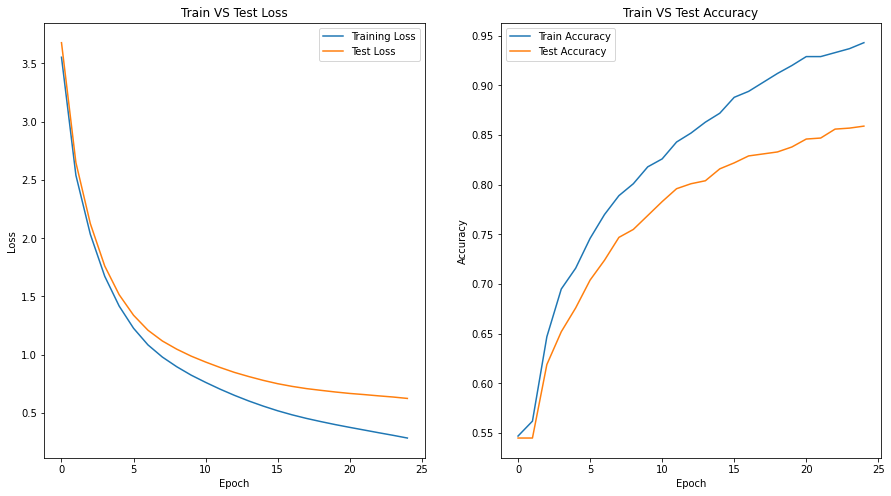

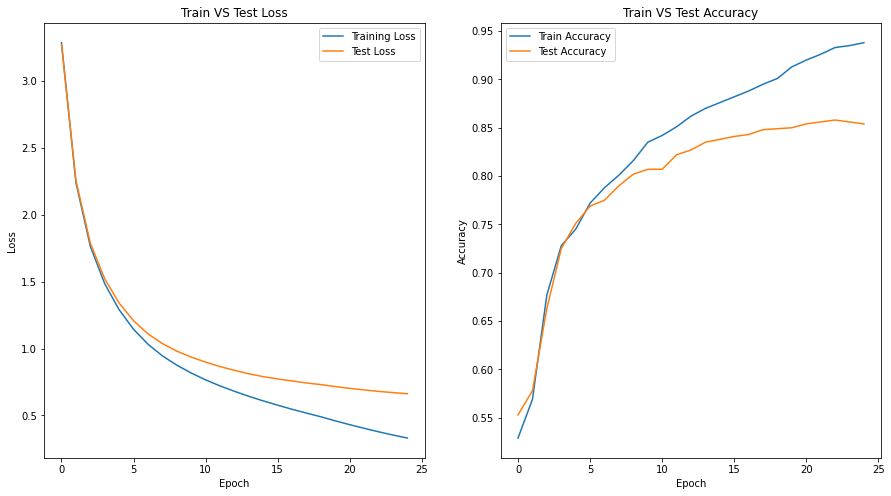

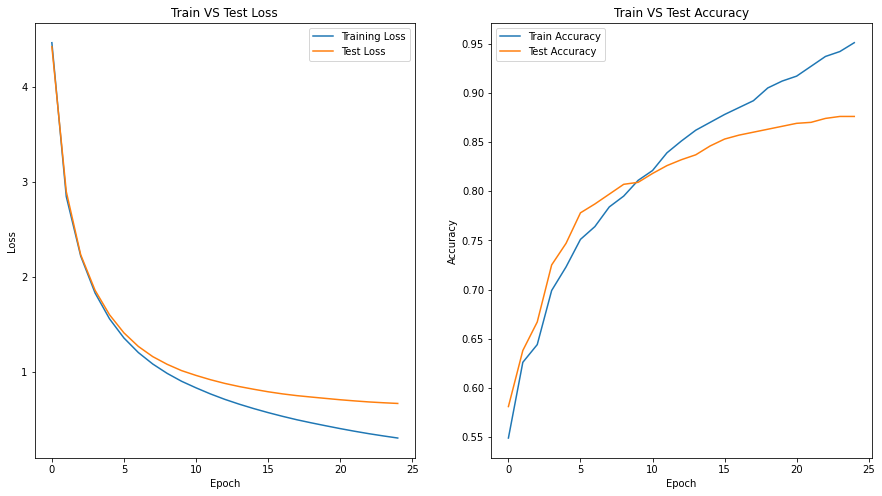

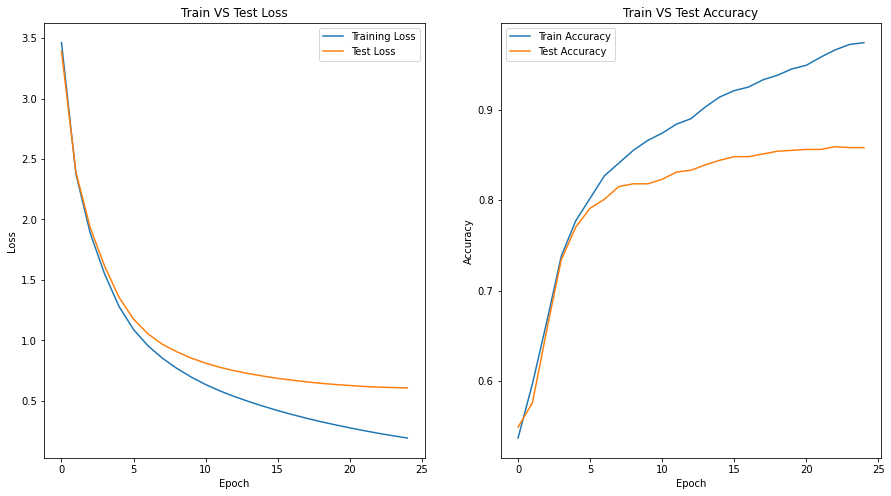

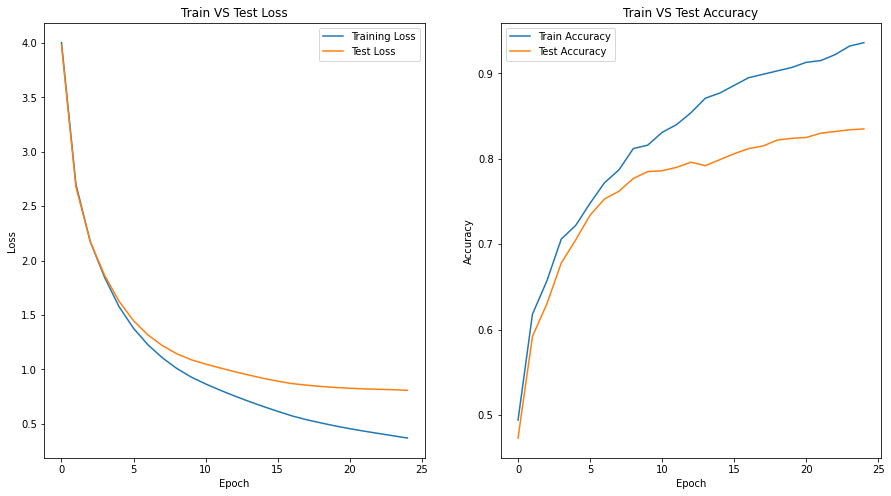

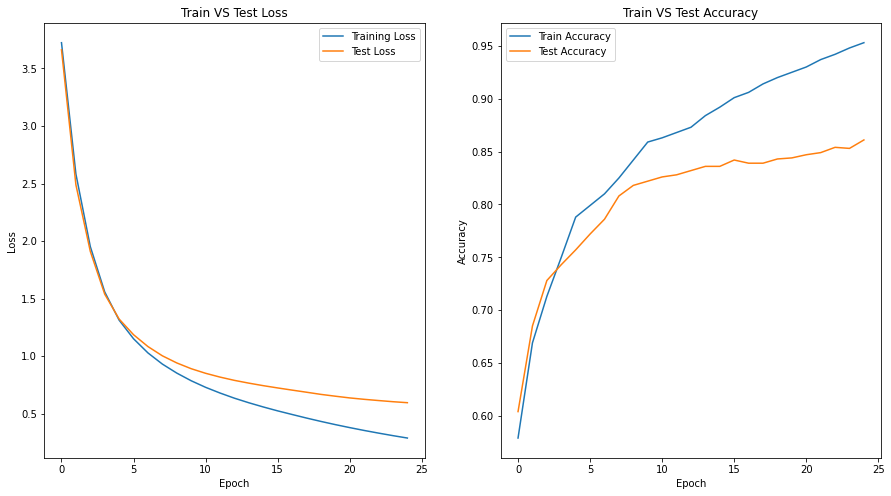

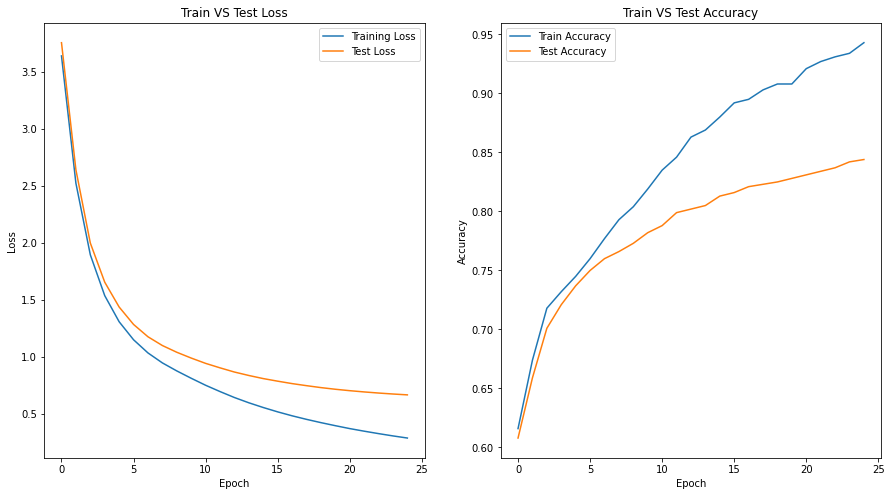

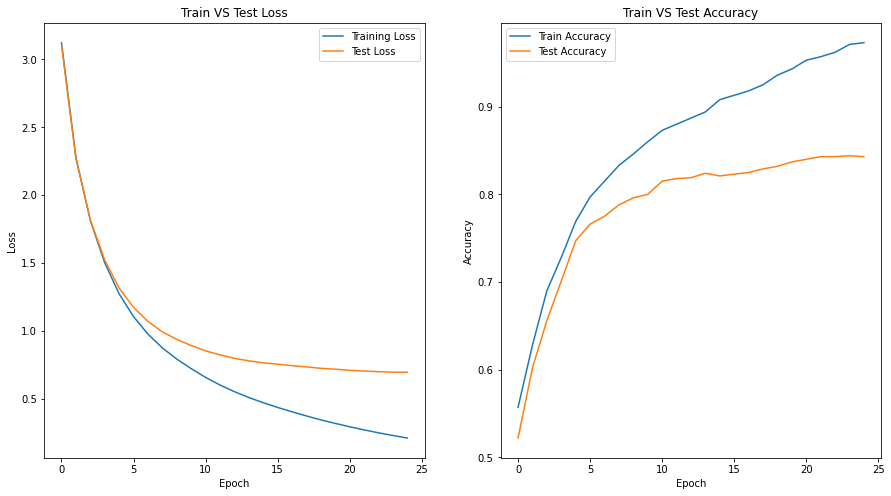

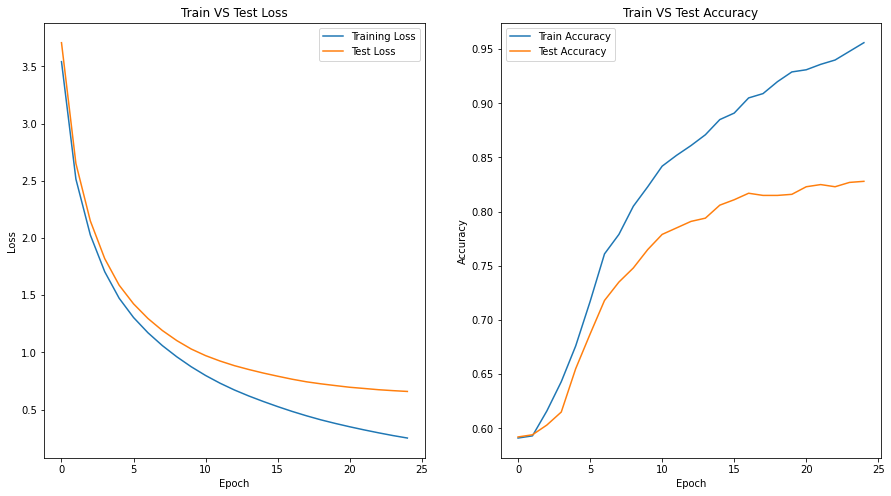

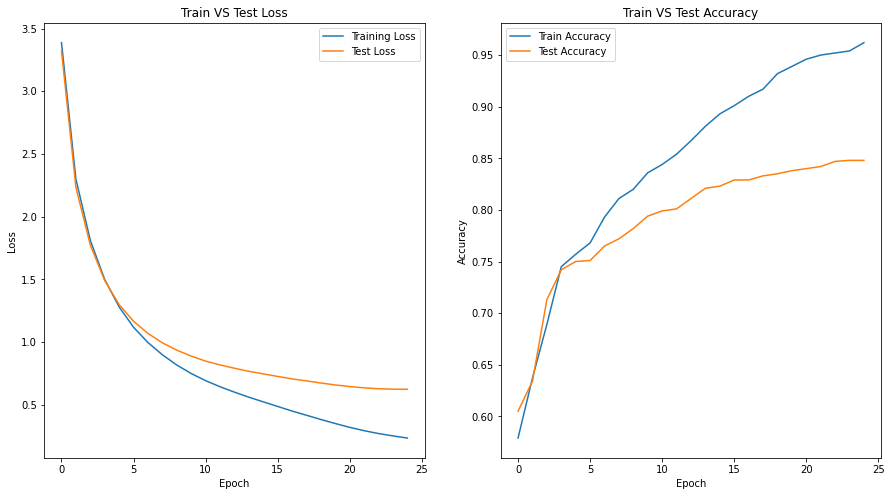

In [11]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = CNN_Net_weight_sharing_auxiliary_loss()
    # train the model
    my_model.trainer(train_input, train_target,train_classes, test_input, test_target, test_classes)
    train_errors.append(my_model.compute_error(train_input, train_target))
    test_errors.append(my_model.compute_error(test_input, test_target))

In [12]:
# print out the deviation and mean value of the training and testing errors
print('The standard deviation of train error:',np.std(train_errors))
print('The standard deviation of test error:',np.std(test_errors))
print('The mean of train error:',np.mean(train_errors))
print('The mean of test error:',np.mean(test_errors))

The standard deviation of train error: 0.012840941133054555
The standard deviation of test error: 0.013237824541396806
The mean of train error: 0.04710000157356262
The mean of test error: 0.14940000772476197


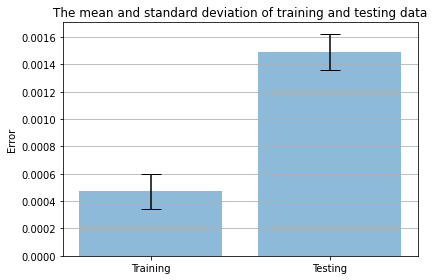

In [13]:
#plot the standard 
# Define labels, positions, bar heights and error bar heights
labels = ['Training', 'Testing']
x_pos = np.arange(len(labels))
means = [np.mean(train_errors)/100, np.mean(test_errors)/100]
stds = [np.std(np.divide(train_errors, 100)), np.std(np.divide(test_errors, 100))]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means,
       yerr=stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('The mean and standard deviation of training and testing data')
ax.yaxis.grid(True)

# show the plot
plt.tight_layout()
plt.show()